## Character Level CNN (CharCNN) based Sentiment and Hate Speech (HS) Classification Experiments

# Hate Speech (HS) binary classification - all data 
# (raw + corrected text saples)

### Social media text preprocessing, analysis, and classification

Character Level CNN (CharCNN) based sentiment and hate speech (HS) classification models use modified version of original CharCNN method.

The scripts were created and published by Merja Kreivi-Kauppinen, and
are part of research work carried in University of Oulu in 2020-2023.

The study is reported on (Master’s Thesis) research paper - 
Merja Kreivi-Kauppinen (2024) Signs of Paradigm Shift in Hate Speech Detection Methodology: Hate Speech Detection of Dialectal, Granular and Urban Finnish. 
University of Oulu, Degree Programme in Computer Science and Engineering. Master’s Thesis, 111 p.


## Original method and references

Original 'Character-level convolutional networks for text classification' -method has been published by Zhang, Zhao, & LeCun (2015) - references:

Zhang, X., Zhao, J., & LeCun, Y. (2015). Character-level convolutional networks for text classification. Advances in neural information processing systems, 28.

Koomsubha, T., & Vateekul, P. (2017). A character-level convolutional neural network with dynamic input length for Thai text categorization. In 2017 9th International Conference on Knowledge and Smart Technology, (2017, February), 101-105. IEEE.

Hints and tips available at GitHub and Web:

https://github.com/BrambleXu/nlp-beginner-guide-keras/blob/f2fdfdd20e73ae16208b3ac63962a769fac51065/char-level-cnn/notebooks/char-level-text-preprocess-with-keras-summary.ipynb

https://github.com/BrambleXu/nlp-beginner-guide-keras/blob/f2fdfdd20e73ae16208b3ac63962a769fac51065/char-level-cnn/notebooks/char-cnn-zhang-with-keras-pipeline.ipynb

Andrew Fogarty http://seekinginference.com/applied_nlp/CharCNN.html

https://github.com/castorini/hedwig

## Install cuda-cudnn-tensorflow-pytorch environment on anaconda

### Check tensorflow, cuda, pytorch, jupyter, python  installations

In [1]:
import sys, re, os, openpyxl
import tqdm
import tqdm as notebook_tqdm

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras
import tensorboard

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from torch.cuda.amp import autocast, GradScaler

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
#print('tensorflow version', tensorflow.__version__)
print('\ntensorboard version: ', tensorboard.__version__)

# Check torch
print('torch version: ', torch.__version__)
#print('torchtext version', torchtext.__version__)

# Check nvidia version
print('\nvcc nvidia version: \n')
!nvcc --version

# Check python
print(f"\nPython Version: {sys.version} \n")
print(sys.executable)
print(sys.version)
print(sys.version_info)
print('\njupyter version: \n')
!jupyter --version

# Check cuda
print('\n\ncudatoolkit version:')

Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

tensorboard version:  2.11.2
torch version:  1.12.1

vcc nvidia version: 

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:59:34_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0

Python Version: 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)] 

C:\Users\merja\anaconda3\envs\NLPtfgpu\python.exe
3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)

jupyter version: 

Selected Jupyter core packages...
IPython          : 8.5.0
ipykernel        : 6.16.0
ipywidgets       : 8.0.2
jupyter_client   : 7.4.2
jupyter_core     : 4.11.1
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.7.0
nbconvert        : 7.2.1
nbformat         : 5.7.0
notebook         : 6.4.12
qtconsole        : not ins

In [2]:
conda list cudatoolkit

# packages in environment at C:\Users\merja\anaconda3\envs\NLPtfgpu:
#
# Name                    Version                   Build  Channel
cudatoolkit               11.6.0              hc0ea762_10    conda-forge

Note: you may need to restart the kernel to use updated packages.


In [3]:
# check GPU
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT available")

# check torch cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

GPU is available


device(type='cuda', index=0)

### Import python packages and libraries

In [4]:
# import python packages and libraries

import time, datetime, random, string
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# set seaborn figures
%matplotlib inline
rcParams['figure.figsize'] = 8, 4
sns.set(style='darkgrid', palette='muted', font_scale=1.0)

### Load data and analyze distribution of data
### Set the string length of data samples

In [5]:
# import data from xlsx file to pd dataFolder
cwd = os.getcwd()
folder = '\\data\\'
csv_file = 'Manually_Annotated_Collection_ALL_FINAL_22023Merja.xlsx'
csv_source = cwd + folder + csv_file
#print(csv_source)

df = pd.read_excel(csv_source)
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,negative,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,Meria
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",negative,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL","- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",Meria
2,3,--´973´¤-.ttu,negative,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,--´973´¤-.ttu,973 vittu,Meria
3,4,-=>Widdu joo<=-,negative,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,-=> Widdu joo <=-,-=> vittu joo <=-,Meria
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",negative,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR","- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",Meria
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,positive,5,False,0,NaN,NaN,NaN,JOY,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,😂😂😂😂😂,Meria
6625,6626,😠👉👩‍💼,negative,-3,False,0,NaN,NaN,NaN,ANGER HATE,😠👉👩‍💼,😠👉👩‍💼,Meria
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,positive,5,False,0,NaN,NaN,NaN,JOY,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,Meria
6627,6628,🤮😡,negative,-4,False,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",🤮😡,🤮😡,Meria


In [6]:
df['HSbinary'] = df['HSbinary'].replace(True, 1)
df['HSbinary'] = df['HSbinary'].replace(False, 0)

# Change text samples to string
df["text"] = df[str("sample")]

# add string len column
df["stringLength"] = ""

# extract string length measures of data
def extract_stringLen(df):
    for item in df["text"]:
        df["stringLength"] = df.text.str.len()
    return df

extract_stringLen(df)
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,text,stringLength
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,negative,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,Meria,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",negative,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL","- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",Meria,"- Kaivovertauksessa, viime hallitus on kaivan...",984
2,3,--´973´¤-.ttu,negative,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,--´973´¤-.ttu,973 vittu,Meria,--´973´¤-.ttu,15
3,4,-=>Widdu joo<=-,negative,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,-=> Widdu joo <=-,-=> vittu joo <=-,Meria,-=>Widdu joo<=-,16
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",negative,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR","- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",Meria,"- Ei , mutta olen joutunut elämään katsomalla ...",148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,positive,5,0,0,NaN,NaN,NaN,JOY,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,😂😂😂😂😂,Meria,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,14
6625,6626,😠👉👩‍💼,negative,-3,0,0,NaN,NaN,NaN,ANGER HATE,😠👉👩‍💼,😠👉👩‍💼,Meria,😠👉👩‍💼,5
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,positive,5,0,0,NaN,NaN,NaN,JOY,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,Meria,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10
6627,6628,🤮😡,negative,-4,0,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",🤮😡,🤮😡,Meria,🤮😡,2


In [7]:
df_raw_samples = df[['HSbinary', 'text', 'stringLength']].copy()
df_raw_samples

,HSbinary,text,stringLength
0,0,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,0,"- Kaivovertauksessa, viime hallitus on kaivan...",984
2,1,--´973´¤-.ttu,15
3,1,-=>Widdu joo<=-,16
4,0,"- Ei , mutta olen joutunut elämään katsomalla ...",148
...,...,...,...
6624,0,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,14
6625,0,😠👉👩‍💼,5
6626,0,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10
6627,0,🤮😡,2


In [8]:
# Change text samples to string
df["text"] = df[str("correct_finnish")]

# add string len column
df["stringLength"] = ""

# extract string length measures of data
def extract_stringLen(df):
    for item in df["text"]:
        df["stringLength"] = df.text.str.len()
    return df

extract_stringLen(df)
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,text,stringLength
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,negative,-1,0,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,Meria,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",negative,-2,0,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL","- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",Meria,"- Kaivovertauksessa, viime hallitus on kaivan...",984
2,3,--´973´¤-.ttu,negative,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,--´973´¤-.ttu,973 vittu,Meria,973 vittu,9
3,4,-=>Widdu joo<=-,negative,-4,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,-=> Widdu joo <=-,-=> vittu joo <=-,Meria,-=> vittu joo <=-,17
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",negative,-5,0,0,NaN,NaN,NaN,"SADNESS, FEAR","- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",Meria,"Ei , mutta olen joutunut elämään katsomalla ku...",144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,positive,5,0,0,NaN,NaN,NaN,JOY,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,😂😂😂😂😂,Meria,😂😂😂😂😂,5
6625,6626,😠👉👩‍💼,negative,-3,0,0,NaN,NaN,NaN,ANGER HATE,😠👉👩‍💼,😠👉👩‍💼,Meria,😠👉👩‍💼,5
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,positive,5,0,0,NaN,NaN,NaN,JOY,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,Meria,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10
6627,6628,🤮😡,negative,-4,0,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",🤮😡,🤮😡,Meria,🤮😡,2


In [9]:
df_correct_samples = df[['HSbinary', 'text', 'stringLength']].copy()
df_correct_samples

,HSbinary,text,stringLength
0,0,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,0,"- Kaivovertauksessa, viime hallitus on kaivan...",984
2,1,973 vittu,9
3,1,-=> vittu joo <=-,17
4,0,"Ei , mutta olen joutunut elämään katsomalla ku...",144
...,...,...,...
6624,0,😂😂😂😂😂,5
6625,0,😠👉👩‍💼,5
6626,0,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10
6627,0,🤮😡,2


In [10]:
# import data from txt file to pd dataFolder

cwd = os.getcwd()
folder = '\\data\\'
file = 'fin_afinn_HS_binary_MerjasList_2023.txt'
source = cwd + folder + file
print(source)

data = []

def delete_new_line(value):
    return ''.join(value.splitlines())

with open(source, "r", encoding='utf-8') as file:
#with open(source, "r") as file:
    lines = file.readlines()
    for line in lines:
        line_items = line.split('\t')        
        if (len(line_items) > 1):
            line_items[1] = delete_new_line(line_items[1])
            data.append(line_items)

# pass the chunks in pd.DataFrame and specify the column names
df = pd.DataFrame(data, columns=["text", "HSbinary"])
df

C:\Users\merja\Desktop\HS_research_project\Char_CNN_Classification\data\fin_afinn_HS_binary_MerjasList_2023.txt


,text,HSbinary
0,öykkäröinti,0
1,öykkäröidä,0
2,öykkärimäisyys,0
3,öykkäri,0
4,ötökkä,0
...,...,...
9985,aarre,0
9986,aarre,0
9987,aaltoilla,0
9988,aalto,0


In [11]:
# Change text samples to string
df["text"] = df[str("text")]

# add string len column
df["stringLength"] = ""

# extract string length measures of data
def extract_stringLen(df):
    for item in df["text"]:
        df["stringLength"] = df.text.str.len()
    return df

extract_stringLen(df)
df

,text,HSbinary,stringLength
0,öykkäröinti,0,11
1,öykkäröidä,0,10
2,öykkärimäisyys,0,14
3,öykkäri,0,7
4,ötökkä,0,6
...,...,...,...
9985,aarre,0,5
9986,aarre,0,5
9987,aaltoilla,0,9
9988,aalto,0,5


In [12]:
df_sentiment_words = df[['HSbinary', 'text', 'stringLength']].copy()
df_sentiment_words

,HSbinary,text,stringLength
0,0,öykkäröinti,11
1,0,öykkäröidä,10
2,0,öykkärimäisyys,14
3,0,öykkäri,7
4,0,ötökkä,6
...,...,...,...
9985,0,aarre,5
9986,0,aarre,5
9987,0,aaltoilla,9
9988,0,aalto,5


## Concatenate training data

In [13]:
# Concatenate training data
new_df = pd.concat([df_raw_samples, df_correct_samples, df_sentiment_words], axis=0)
new_df

,HSbinary,text,stringLength
0,0,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,0,"- Kaivovertauksessa, viime hallitus on kaivan...",984
2,1,--´973´¤-.ttu,15
3,1,-=>Widdu joo<=-,16
4,0,"- Ei , mutta olen joutunut elämään katsomalla ...",148
...,...,...,...
9985,0,aarre,5
9986,0,aarre,5
9987,0,aaltoilla,9
9988,0,aalto,5


In [14]:
# Indicate missing values.
#df.isna
new_df.isna().sum().sum()

0

In [15]:
# Drop the rows where at least one element is missing.
df = new_df.dropna()
df

,HSbinary,text,stringLength
0,0,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,0,"- Kaivovertauksessa, viime hallitus on kaivan...",984
2,1,--´973´¤-.ttu,15
3,1,-=>Widdu joo<=-,16
4,0,"- Ei , mutta olen joutunut elämään katsomalla ...",148
...,...,...,...
9985,0,aarre,5
9986,0,aarre,5
9987,0,aaltoilla,9
9988,0,aalto,5


In [16]:
# Indicate missing values.
#df.isna
df.isna().sum().sum()

0

In [17]:
# change polarity int64 values to sring
df['HSbinary'] = df['HSbinary'].astype('int32')
type(df['HSbinary'].iloc[0])

numpy.int32

In [18]:
# remove doubles
new_df = df.drop_duplicates(subset=['text'])
df = new_df
df

,HSbinary,text,stringLength
0,0,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,0,"- Kaivovertauksessa, viime hallitus on kaivan...",984
2,1,--´973´¤-.ttu,15
3,1,-=>Widdu joo<=-,16
4,0,"- Ei , mutta olen joutunut elämään katsomalla ...",148
...,...,...,...
9984,0,aarteet,7
9985,0,aarre,5
9987,0,aaltoilla,9
9988,0,aalto,5


### Analyze Concatenated Sentiment Data

Min text data length is:   1
Max text data length is:   835
Mean text data length is:   35.56483040654318
The standard deviation is:   71.69606324979785
The data count is:   20785


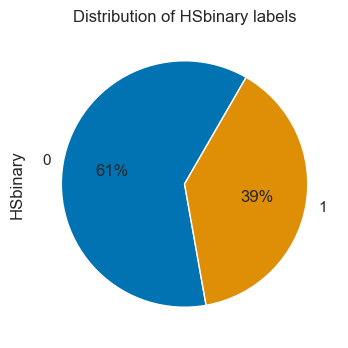

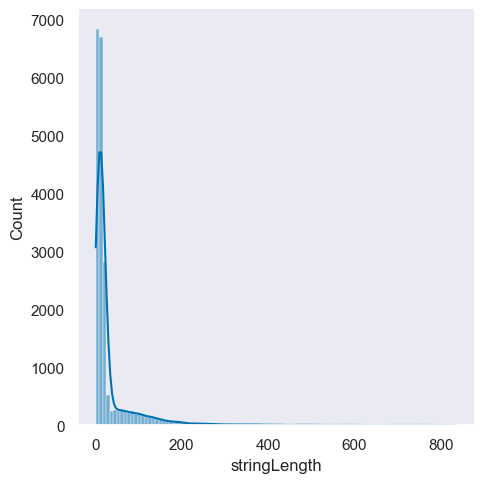

In [19]:
MIN_LENGTH = int(0)
MAX_LENGTH = int(850)

minDF = df[df["stringLength"] > MIN_LENGTH]
largeDF = minDF[minDF["stringLength"] <= MAX_LENGTH] 

print("Min text data length is:  ", largeDF.text.str.len().min())

# Define the longest string length in data
print("Max text data length is:  ", largeDF.text.str.len().max())

# Define the mean string length in data
print("Mean text data length is:  ", largeDF.text.str.len().mean())

# Define the standard deviation in string length
print("The standard deviation is:  ", largeDF["stringLength"].std())

# Define len of data
print("The data count is:  ", len(largeDF))

sns.set_theme(style='dark', palette='colorblind', font_scale=1.0)
rcParams['figure.figsize'] = 3, 3

largeDF['HSbinary'].value_counts().plot(kind='pie', 
                                          figsize=(4, 4),
                                          autopct='%1.0f%%', 
                                          #colors=['silver', 'pink'], 
                                          #explode = (0.05, 0.05), 
                                          startangle=60, 
                                          title='Distribution of HSbinary labels')

sns.displot(largeDF, x="stringLength", bins=103, kde=True)
#sns.pairplot(largeDF, hue='sentiment')
#largeDF

In [20]:
# Define groups 64, 128, 256, 850 and all samples

xshortSamples = df[df["stringLength"] <= 64 ] 
print("data size of xshort Samples ", len(xshortSamples))

shortSamples = df[df["stringLength"] <= 128]
print("data size of short Samples ", len(shortSamples))

mediumSamples = df[df["stringLength"] <= 256]
print("data size of medium Samples ", len(mediumSamples))

longSamples = df[df["stringLength"] <= 850]
print("data size of long Samples ", len(longSamples))

print("data size of all Samples ", len(df))

data size of xshort Samples  17854
data size of short Samples  19427
data size of medium Samples  20391
data size of long Samples  20785
data size of all Samples  20820


## Set up character level tokenizer with Keras libraries

Character level preprocessing, tokenization and indexing of raw text (samples) to idexed sequences is carried with tokenizers of Keras NLP library.

At first extented vocabulary list of characters including some special chars of finnish, nordic, and european languages (tokens), and index list of defined tokens were used to define project specified tokenizer (charTokenizer).

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [22]:
# Define Keras Tokenizer
# Add 'UNK' to the vocabulary for unknown tokens and empty spaces
charTokenizer = Tokenizer(num_words=None, filters='', lower=False, char_level=True, oov_token='UNK')
charTokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': ' ',
 'char_level': True,
 'oov_token': 'UNK',
 'document_count': 0,
 'word_counts': '{}',
 'word_docs': '{}',
 'index_docs': '{}',
 'index_word': '{}',
 'word_index': '{}'}

In [23]:
# add extented character list including special chars of finnish
vocab_chars = 'abcdefghijklmnopqrstuvwxyzäöåéíßABCDEFGHIJKLMNOPQRSTUVWXYZÄÖÅÉÍ1234567890!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~´”€|£'
vocab_chars = str(vocab_chars)
vocab_chars

'abcdefghijklmnopqrstuvwxyzäöåéíßABCDEFGHIJKLMNOPQRSTUVWXYZÄÖÅÉÍ1234567890!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~´”€|£'

In [24]:
# Define index for tokens of the characters + 1 for 'UNK'
token_index = dict(zip(vocab_chars, range(1, len(vocab_chars) + 1)))
print(token_index)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'ä': 27, 'ö': 28, 'å': 29, 'é': 30, 'í': 31, 'ß': 32, 'A': 33, 'B': 34, 'C': 35, 'D': 36, 'E': 37, 'F': 38, 'G': 39, 'H': 40, 'I': 41, 'J': 42, 'K': 43, 'L': 44, 'M': 45, 'N': 46, 'O': 47, 'P': 48, 'Q': 49, 'R': 50, 'S': 51, 'T': 52, 'U': 53, 'V': 54, 'W': 55, 'X': 56, 'Y': 57, 'Z': 58, 'Ä': 59, 'Ö': 60, 'Å': 61, 'É': 62, 'Í': 63, '1': 64, '2': 65, '3': 66, '4': 67, '5': 68, '6': 69, '7': 70, '8': 71, '9': 72, '0': 73, '!': 74, '"': 75, '#': 76, '$': 77, '%': 78, '&': 79, "'": 80, '(': 81, ')': 82, '*': 83, '+': 84, ',': 85, '-': 86, '.': 87, '/': 88, ':': 89, ';': 90, '<': 91, '=': 92, '>': 93, '?': 94, '@': 95, '[': 96, '\\': 97, ']': 98, '^': 99, '_': 100, '`': 101, '{': 102, '|': 109, '}': 104, '~': 105, '´': 106, '”': 107, '€': 108, '£': 110}


In [25]:
# Define vocab_size of tokenization vocabulary
vocab_size = len(token_index)
vocab_size

109

In [26]:
# Use token_index dict to replace the tk.word_index
charTokenizer.word_index = token_index

In [27]:
charTokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': ' ',
 'char_level': True,
 'oov_token': 'UNK',
 'document_count': 0,
 'word_counts': '{}',
 'word_docs': '{}',
 'index_docs': '{}',
 'index_word': '{}',
 'word_index': '{"a": 1, "b": 2, "c": 3, "d": 4, "e": 5, "f": 6, "g": 7, "h": 8, "i": 9, "j": 10, "k": 11, "l": 12, "m": 13, "n": 14, "o": 15, "p": 16, "q": 17, "r": 18, "s": 19, "t": 20, "u": 21, "v": 22, "w": 23, "x": 24, "y": 25, "z": 26, "\\u00e4": 27, "\\u00f6": 28, "\\u00e5": 29, "\\u00e9": 30, "\\u00ed": 31, "\\u00df": 32, "A": 33, "B": 34, "C": 35, "D": 36, "E": 37, "F": 38, "G": 39, "H": 40, "I": 41, "J": 42, "K": 43, "L": 44, "M": 45, "N": 46, "O": 47, "P": 48, "Q": 49, "R": 50, "S": 51, "T": 52, "U": 53, "V": 54, "W": 55, "X": 56, "Y": 57, "Z": 58, "\\u00c4": 59, "\\u00d6": 60, "\\u00c5": 61, "\\u00c9": 62, "\\u00cd": 63, "1": 64, "2": 65, "3": 66, "4": 67, "5": 68, "6": 69, "7": 70, "8": 71, "9": 72, "0": 73, "!": 74, "\\"": 75, "#": 76, "$": 77, "%": 78, "&": 7

In [28]:
# Add 'UNK' to the vocabulary
charTokenizer.word_index[charTokenizer.oov_token] = max(charTokenizer.word_index.values())+1
# check
charTokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': ' ',
 'char_level': True,
 'oov_token': 'UNK',
 'document_count': 0,
 'word_counts': '{}',
 'word_docs': '{}',
 'index_docs': '{}',
 'index_word': '{}',
 'word_index': '{"a": 1, "b": 2, "c": 3, "d": 4, "e": 5, "f": 6, "g": 7, "h": 8, "i": 9, "j": 10, "k": 11, "l": 12, "m": 13, "n": 14, "o": 15, "p": 16, "q": 17, "r": 18, "s": 19, "t": 20, "u": 21, "v": 22, "w": 23, "x": 24, "y": 25, "z": 26, "\\u00e4": 27, "\\u00f6": 28, "\\u00e5": 29, "\\u00e9": 30, "\\u00ed": 31, "\\u00df": 32, "A": 33, "B": 34, "C": 35, "D": 36, "E": 37, "F": 38, "G": 39, "H": 40, "I": 41, "J": 42, "K": 43, "L": 44, "M": 45, "N": 46, "O": 47, "P": 48, "Q": 49, "R": 50, "S": 51, "T": 52, "U": 53, "V": 54, "W": 55, "X": 56, "Y": 57, "Z": 58, "\\u00c4": 59, "\\u00d6": 60, "\\u00c5": 61, "\\u00c9": 62, "\\u00cd": 63, "1": 64, "2": 65, "3": 66, "4": 67, "5": 68, "6": 69, "7": 70, "8": 71, "9": 72, "0": 73, "!": 74, "\\"": 75, "#": 76, "$": 77, "%": 78, "&": 7

In [29]:
# Define vocab_size of char tokenizer vocabulary 
# + 1 for 'UNK'
# + 1 for 'PAD' (0)
vocab_size = len(charTokenizer.word_index) +1 +1
vocab_size

112

## Test one-hot encoding for text data

Preprocess text by converting text format to tokens and index values. During preprocessing steps text samples are padded to max length and multiplied with identity matrice sized according to vocab size.

In [30]:
# set dataset - set string length for dataset samples
min_length = int(0)
max_length = int(850)
minDF = df[df["stringLength"] > min_length]
largeDF = minDF[minDF["stringLength"] <= max_length]
df = largeDF

text_samples = df['text'].values    

#text_samples
len(text_samples)

20785

# Define datasets, samplers, and dataloaders
Next we proceed with the usual task of preparing our TensorDataset, data loaders, a time helper function, and a weighted random sampler to help account for class imbalance during training.

In [31]:
type(df['HSbinary'].iloc[0])

numpy.int32

In [32]:
# set dataset
#df = mediumDF
#df = largeDF

# set labels
labels = {'0':0,
          '1':1,
          }

# set MAX_LENGTH
#MAX_LENGTH = 256
#MAX_LENGTH = 512
MAX_LENGTH = 850

# define batch size - 2, 4, 8, 16, 32, 64, or 128
batch_size = 16

In [33]:
# randomize everything
RANDOM_SEED = 123
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.cuda.amp.autocast(enabled=True)

In [34]:
train_data, val_data, test_data = np.split(df.sample(frac=1, random_state=RANDOM_SEED),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(train_data), len(val_data), len(test_data))

16628 2078 2079


In [35]:
# set dataset class

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        
        self.labels = [label for label in df['HSbinary']]
        
        self.text_samples = df['text'].values
        
        # Convert string to index
        text_tokens = charTokenizer.texts_to_sequences(self.text_samples)
        # Padding - input size - max len = MAX_LENGTH
        pad_texts = pad_sequences(text_tokens, maxlen=MAX_LENGTH, padding='post')
        
        datamat = []
        for item in pad_texts:
            #coded_text = item[idx]
            identity_mat = np.identity(vocab_size)
            data_mat = np.array([identity_mat[item]])
            data_mat = data_mat[0]
            datamat.append(data_mat)
            
        # NO NEED TO RESHAPE
        self.texts = np.asarray(datamat, dtype=np.float32)
        
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_texts, batch_labels

In [36]:
# create tensor data sets
train_dataset, val_dataset, test_dataset = Dataset(train_data), Dataset(val_data), Dataset(test_data)

len(train_dataset), len(val_dataset), len(test_dataset)

(16628, 2078, 2079)

In [37]:
# helper function to count target distribution inside tensor data sets
def target_count(tensor_dataset):
    # set empty count containers
    count0 = 0
    count1 = 0
    # set total container to turn into torch tensor
    total = []
    # for every item in the tensor data set
    for i in tensor_dataset:
        # if the target is equal to 0
        if i[1].item() == 0:
            count0 += 1
        # if the target is equal to 1
        elif i[1].item() == 1:
            count1 += 1
    total.append(count0)
    total.append(count1)
    return torch.tensor(total)

In [38]:
# prepare weighted sampling for imbalanced classification
def create_sampler(target_tensor, tensor_dataset):
    # generate class distributions [x, y]
    class_sample_count = target_count(tensor_dataset)
    # weight
    weight = 1. / class_sample_count.float()
    # produce weights for each observation in the data set
    samples_weight = torch.tensor([weight[t[1]] for t in tensor_dataset])
    # prepare sampler
    sampler = torch.utils.data.WeightedRandomSampler(weights=samples_weight,
                                                     num_samples=len(samples_weight),
                                                     replacement=True)
    return sampler


In [39]:
# create samplers for each data set
train_sampler = create_sampler(target_count(train_dataset), train_dataset)

In [40]:
# create dataLoaders with samplers
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, shuffle=False, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

## Define Character level CNN
Set CharCNN class and configuration class.

In [41]:
class CharCNN(nn.Module):

    def __init__(self, config):
        super().__init__()
        
        input_channels = config.input_channels
        num_conv_filters = config.num_conv_filters
        output_channel = config.output_channel
        num_affine_neurons = config.num_affine_neurons
        target_class = config.target_class

        self.conv1 = nn.Conv1d(input_channels, num_conv_filters, kernel_size=7)
        self.conv2 = nn.Conv1d(num_conv_filters, num_conv_filters, kernel_size=7)
        self.conv3 = nn.Conv1d(num_conv_filters, num_conv_filters, kernel_size=5)
        self.conv4 = nn.Conv1d(num_conv_filters, num_conv_filters, kernel_size=5)
        self.conv5 = nn.Conv1d(num_conv_filters, num_conv_filters, kernel_size=3)
        self.conv6 = nn.Conv1d(num_conv_filters, output_channel, kernel_size=3)

        self.dropout = nn.Dropout(config.dropout)
        
        self.fc1 = nn.Linear(output_channel, num_affine_neurons)
        self.fc2 = nn.Linear(num_affine_neurons, num_affine_neurons)
        self.fc3 = nn.Linear(num_affine_neurons, target_class)
        
        # softmax activation function 
        self.softmax = nn.LogSoftmax(dim=1)
        
        # add weights to conv and linear layers
        if num_conv_filters == 850 and num_affine_neurons == 850:
            self.create_weights(mean=0.0, std=0.01)
        if num_conv_filters == 850 and num_affine_neurons == 1700:
            self.create_weights(mean=0.0, std=0.01)
        elif num_conv_filters == 850 and num_affine_neurons == 3400:
            self.create_weights(mean=0.0, std=0.01)

    def create_weights(self, mean=0.0, std=0.05):
        for module in self.modules():
            if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
                module.weight.data.normal_(mean, std)

    def forward(self, x, **kwargs):
        # transpose of embedding matrice
        x = x.transpose(1, 2).type(torch.cuda.FloatTensor)
        
        x = F.max_pool1d(F.relu(self.conv1(x)), 3)
        x = F.max_pool1d(F.relu(self.conv2(x)), 3)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        # softmax activation 
        x = self.softmax(x)
        return x

In [42]:
# set CharCNN model configuration class

class config:
    def __init__(self):
        config.num_conv_filters = MAX_LENGTH
        config.output_channel = MAX_LENGTH
        config.num_affine_neurons = 4 * MAX_LENGTH
        #config.num_affine_neurons = 3 * MAX_LENGTH
        #config.num_affine_neurons = 2 * MAX_LENGTH
        #config.num_affine_neurons = MAX_LENGTH
        config.target_class = 2
        config.dropout = 0.5
        # vocab_size = 112
        config.input_channels = vocab_size 
        return None

# check network
config1 = config()
model = CharCNN(config1)
model

CharCNN(
  (conv1): Conv1d(112, 850, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(850, 850, kernel_size=(7,), stride=(1,))
  (conv3): Conv1d(850, 850, kernel_size=(5,), stride=(1,))
  (conv4): Conv1d(850, 850, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(850, 850, kernel_size=(3,), stride=(1,))
  (conv6): Conv1d(850, 850, kernel_size=(3,), stride=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=850, out_features=3400, bias=True)
  (fc2): Linear(in_features=3400, out_features=3400, bias=True)
  (fc3): Linear(in_features=3400, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

## Training and validating functions
Set up utilize common training and validating functions.

In [43]:
# time function
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [44]:
# training function

def train(model, dataloader, optimizer, criterion):

    # capture time
    total_t0 = time.time()

    # Perform one full pass over the training set
    # train all samples in one epoch
    print('\nEpoch {:} / {:} -----------------------------------------'.format(epoch + 1, epochs))
    
    # reset total loss for epoch
    train_total_loss = 0
    total_train_f1 = 0
    total_train_accuracy = 0

    # put model into traning mode
    model.train()

    # for each batch of training data...
    for step, batch in enumerate(dataloader):

        # progress update every 40 batches.
        #if step % 40 == 0 and not step == 0:

            # Report progress.
            #print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))

        # Unpack this training batch from our dataloader:
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU
        #
        # `batch` contains two pytorch tensors:
        #   [0]: input ids
        #   [1]: labels
        b_input_ids = batch[0].cuda()
        b_labels = batch[1].cuda().long()

        # clear previously calculated gradients
        optimizer.zero_grad()

        with autocast():
            # forward propagation (evaluate model on training batch)
            logits = model(b_input_ids)

        # calculate cross entropy loss
        loss = criterion(logits.view(-1, 2), b_labels.view(-1))

        # sum the training loss over all batches for average loss at end
        # loss is a tensor containing a single value
        train_total_loss += loss.item()
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
        # Backward passes under autocast are not recommended.
        # Backward ops run in the same dtype autocast chose for corresponding forward ops.
        ##scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        ##scaler.step(optimizer)

        # Updates the scale for next iteration.
        ##scaler.update()

        # update the learning rate
        ##scheduler.step()

        # get preds
        _, predicted = torch.max(logits, 1)

        # move logits and labels to CPU
        predicted = predicted.detach().cpu().numpy()
        y_true = b_labels.detach().cpu().numpy()

        # calculate f1-score
        total_train_f1 += f1_score(predicted, y_true,
                                   average='weighted',
                                   labels=np.unique(predicted))
        
        # calculate accuracy
        total_train_accuracy += accuracy_score(y_true, predicted, 
                                               #normalize=False, 
                                               normalize=True,
                                               sample_weight=None)
        
        
    # calculate the average loss over all of the batches
    avg_train_loss = train_total_loss / len(dataloader)

    # calculate the average f1 over all of the batches
    avg_train_f1 = total_train_f1 / len(dataloader)
    
    # calculate the accuracy of over all of the batches (one epoch)
    avg_train_accuracy = total_train_accuracy / len(dataloader)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Train Loss': avg_train_loss,
            'Train Accuracy': avg_train_accuracy,
            'Train f1': avg_train_f1,
        }
    )

    # training time end
    training_time = format_time(time.time() - total_t0)

    # print result summaries
    print("\nTraining results as average of bathes in one epoch")
    print("epoch | train time | train loss | train f1 | train accuracy")
    print(f"{epoch+1:5d} | {training_time:} | {avg_train_loss:.5f} | {avg_train_f1:.5f} | {avg_train_accuracy:.5f}")
    #print(f"{epoch+1:5d} | {avg_train_loss:.5f} | {avg_train_f1:.5f} | {training_time:}")

    torch.cuda.empty_cache()

    return None


In [45]:
# validating function

def validating(model, dataloader, criterion):

    # capture validation time
    total_t0 = time.time()

    # After the completion of each training epoch, measure our performance on
    # our validation set.
    #print("... Running Validation...")

    # put the model in evaluation mode
    model.eval()

    # track variables
    total_valid_accuracy = 0
    total_valid_loss = 0
    total_valid_f1 = 0
    total_valid_recall = 0
    total_valid_precision = 0

    # evaluate data for one epoch
    for batch in dataloader:

        # unpack batch from dataloader
        b_input_ids = batch[0].cuda()
        b_labels = batch[1].cuda().long()

        # tell pytorch not to bother calculating gradients
        # as its only necessary for training
        with torch.no_grad():

            # forward propagation (evaluate model on training batch)
            logits = model(b_input_ids)

            # calculate BCEWithLogitsLoss
            loss = criterion(logits.view(-1, 2), b_labels.view(-1))

            # calculate preds
            _, predicted = torch.max(logits, 1)

        # accumulate validation loss
        total_valid_loss += loss.item()

        # move logits and labels to CPU
        predicted = predicted.detach().cpu().numpy()
        y_true = b_labels.detach().cpu().numpy()

        # calculate f1
        total_valid_f1 += f1_score(y_true, predicted, 
                                   average='weighted', 
                                   labels=np.unique(predicted), 
                                   zero_division=0)
        # calculate accuracy
        total_valid_accuracy += accuracy_score(y_true, predicted, 
                                               normalize=True,
                                               sample_weight=None)

        # calculate precision
        total_valid_precision += precision_score(y_true, predicted, 
                                                 labels=np.unique(predicted), pos_label=1, 
                                                 average='binary', sample_weight=None, zero_division=0)
        
        # calculate recall
        total_valid_recall += recall_score(y_true, predicted, 
                                           labels=np.unique(predicted), pos_label=1, 
                                           average='binary', sample_weight=None, zero_division=0)

    # report final accuracy of validation run
    avg_valid_accuracy = total_valid_accuracy / len(dataloader)

    # report final f1 of validation run
    global avg_valid_f1
    avg_valid_f1 = total_valid_f1 / len(dataloader)

    # report final f1 of validation run
    avg_precision = total_valid_precision / len(dataloader)

    # report final f1 of validation run
    avg_recall = total_valid_recall / len(dataloader)

    # calculate the average loss over all of the batches.
    avg_valid_loss = total_valid_loss / len(dataloader)

    # Record all statistics from this epoch.
    valid_stats.append(
        {
            'Val Loss': avg_valid_loss,
            'Val Accuracy': avg_valid_accuracy,
            'Val Precision': avg_precision,
            'Val Recall': avg_recall,
            'Val f1': avg_valid_f1
        }
    )

    # capture end validation time
    valid_time = format_time(time.time() - total_t0)

    # print result summaries
    print("\nValidation results as average for all validation batches")
    print("epoch | valid time | valid loss | valid f1 | valid accuracy")
    print(f"{epoch+1:5d} | {valid_time:} | {avg_valid_loss:.5f} | {avg_valid_f1:.5f} | {avg_valid_accuracy:.5f}")

    return None

## Training

In [46]:
# set net configuration and net
config1 = config()
model = CharCNN(config1).cuda()

# set loss
criterion = nn.CrossEntropyLoss()

# set number of epochs
epochs = 80

# set optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00000099, weight_decay=0.3) 
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.000099, weight_decay=0.3)             #11 0.251	0.927	0.937	0.927	0.927
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.000099, eps=1e-8)                     ### 6 - 0.227	0.929	0.94	0.929	0.929
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.000099)                               # 0.243	0.922	0.932	0.922	0.922

# set LR scheduler --------------------------------------------------------
#total_steps = len(train_dataloader) * epochs
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# create gradient scaler for mixed precision
#scaler = GradScaler()

# create training result storage
training_stats = []
valid_stats = []
best_valid_loss = float('inf')

print('\nTraining and validation .... ')

# measure training time - timestamp for start of training
time_t0 = time.time()
print('Start training timestamp:  ', format_time(time_t0))
print('')

# for each epoch
for epoch in range(epochs):
    # train
    train(model, train_dataloader, optimizer, criterion)
    # validate
    validating(model, valid_dataloader, criterion)
    # check validation loss
    if valid_stats[epoch]['Val Loss'] < best_valid_loss:
        best_valid_loss = valid_stats[epoch]['Val Loss']
        # save the best model for later use
        torch.save(model.state_dict(), 'char-cnn-hsbinary-large-model1.pt')

print('\nFinished training and validation')

# timestamp for end of training
timeFinish = format_time(time.time())

# calculate training time
training_time = format_time(time.time() - time_t0)
print('\nFinished train timestamp: ', timeFinish, '  Training time: ', training_time)



Training and validation .... 
Start training timestamp:   19801 days, 18:20:59


Epoch 1 / 80 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train time | train loss | train f1 | train accuracy
    1 | 0:00:50 | 0.69316 | 0.50209 | 0.49687

Validation results as average for all validation batches
epoch | valid time | valid loss | valid f1 | valid accuracy
    1 | 0:00:03 | 0.69261 | 0.75688 | 0.61773

Epoch 2 / 80 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train time | train loss | train f1 | train accuracy
    2 | 0:00:41 | 0.69320 | 0.50178 | 0.49537

Validation results as average for all validation batches
epoch | valid time | valid loss | valid f1 | valid accuracy
    2 | 0:00:03 | 0.69320 | 0.38166 | 0.40165

Epoch 3 / 80 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train time | train loss | train f1 | train accu


Validation results as average for all validation batches
epoch | valid time | valid loss | valid f1 | valid accuracy
   22 | 0:00:03 | 0.35211 | 0.84394 | 0.84593

Epoch 23 / 80 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train time | train loss | train f1 | train accuracy
   23 | 0:00:42 | 0.37364 | 0.82956 | 0.82862

Validation results as average for all validation batches
epoch | valid time | valid loss | valid f1 | valid accuracy
   23 | 0:00:03 | 0.35387 | 0.83901 | 0.84109

Epoch 24 / 80 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train time | train loss | train f1 | train accuracy
   24 | 0:00:42 | 0.36513 | 0.83964 | 0.83861

Validation results as average for all validation batches
epoch | valid time | valid loss | valid f1 | valid accuracy
   24 | 0:00:03 | 0.36245 | 0.83503 | 0.83333

Epoch 25 / 80 -----------------------------------------

Training results as 


Validation results as average for all validation batches
epoch | valid time | valid loss | valid f1 | valid accuracy
   44 | 0:00:03 | 0.29466 | 0.88656 | 0.88614

Epoch 45 / 80 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train time | train loss | train f1 | train accuracy
   45 | 0:00:42 | 0.26992 | 0.89172 | 0.89124

Validation results as average for all validation batches
epoch | valid time | valid loss | valid f1 | valid accuracy
   45 | 0:00:03 | 0.27887 | 0.89131 | 0.89147

Epoch 46 / 80 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train time | train loss | train f1 | train accuracy
   46 | 0:00:42 | 0.27458 | 0.89090 | 0.89022

Validation results as average for all validation batches
epoch | valid time | valid loss | valid f1 | valid accuracy
   46 | 0:00:03 | 0.28216 | 0.89206 | 0.89244

Epoch 47 / 80 -----------------------------------------

Training results as 


Validation results as average for all validation batches
epoch | valid time | valid loss | valid f1 | valid accuracy
   66 | 0:00:03 | 0.26285 | 0.89698 | 0.89680

Epoch 67 / 80 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train time | train loss | train f1 | train accuracy
   67 | 0:00:42 | 0.16803 | 0.94448 | 0.94454

Validation results as average for all validation batches
epoch | valid time | valid loss | valid f1 | valid accuracy
   67 | 0:00:03 | 0.24859 | 0.90252 | 0.90407

Epoch 68 / 80 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train time | train loss | train f1 | train accuracy
   68 | 0:00:42 | 0.15752 | 0.94743 | 0.94749

Validation results as average for all validation batches
epoch | valid time | valid loss | valid f1 | valid accuracy
   68 | 0:00:03 | 0.26284 | 0.89553 | 0.89486

Epoch 69 / 80 -----------------------------------------

Training results as 

## Evaluate training and validation results

In [47]:
# get training and validation results from data
df_train_stats = pd.DataFrame(data=training_stats)
df_valid_stats = pd.DataFrame(data=valid_stats)
# create dataframe
df_stats = pd.concat([df_train_stats, df_valid_stats], axis=1)
# set print out options
pd.set_option('display.precision', 3)
# set epochs
df_stats.insert(0, 'Epoch', range(1, len(df_stats)+1))
df_stats = df_stats.set_index('Epoch')
# print out
df_stats.tail(40)

,Train Loss,Train Accuracy,Train f1,Val Loss,Val Accuracy,Val Precision,Val Recall,Val f1
Epoch,,,,,,,,
41,0.292,0.880,0.880,0.292,0.887,0.878,0.827,0.886
42,0.285,0.885,0.885,0.324,0.857,0.785,0.889,0.858
43,0.278,0.886,0.887,0.282,0.889,0.915,0.783,0.885
44,0.280,0.887,0.888,0.295,0.886,0.846,0.864,0.887
45,0.270,0.891,0.892,0.279,0.891,0.875,0.827,0.891
46,0.275,0.890,0.891,0.282,0.892,0.870,0.862,0.892
47,0.254,0.904,0.904,0.281,0.894,0.875,0.837,0.894
48,0.256,0.900,0.901,0.277,0.894,0.875,0.835,0.893
49,0.255,0.903,0.903,0.269,0.896,0.915,0.809,0.894


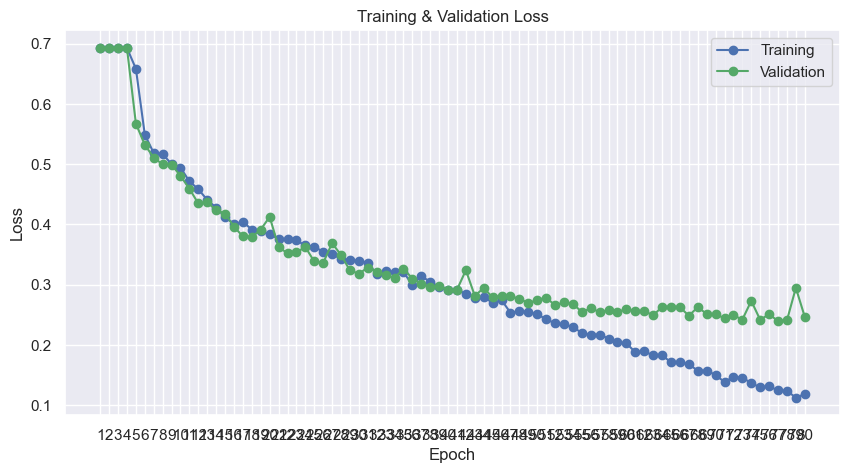

In [48]:
# plot learning curve (loss) results

def plot_results(df):
    # set seaborn style
    sns.set(style='darkgrid')
    # set plot and font size
    sns.set(font_scale=1.0)
    plt.rcParams["figure.figsize"] = (10,5)
    # set plot of learning curve
    plt.plot(df_stats['Train Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Val Loss'], 'g-o', label="Validation")
    # set plot labels and print out
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(list(range(1, epochs+1)))
    return plt.show()

plot_results(df_stats)


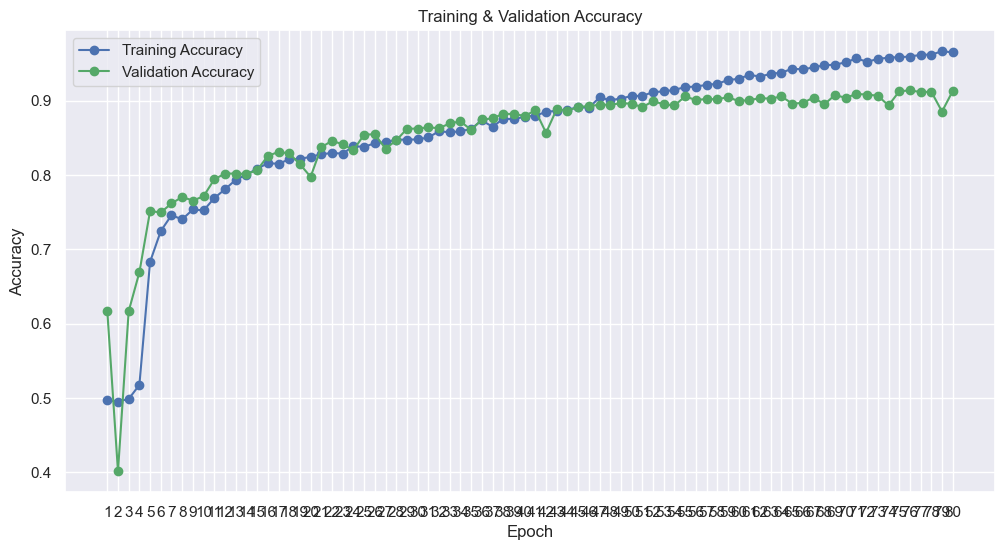

In [49]:
# plot accuracy results

def plot_accuracy_curves(df):
    # set seaborn style
    sns.set(style='darkgrid')
    sns.set(font_scale=1.0)
    plt.rcParams["figure.figsize"] = (12,6)
    # set plot of accuracy
    plt.plot(df_stats['Train Accuracy'], 'b-o', label="Training Accuracy")
    plt.plot(df_stats['Val Accuracy'], 'g-o', label="Validation Accuracy")
    # set plot labels and print out
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.xticks(list(range(1, epochs+1)))
    return plt.show()

plot_accuracy_curves(df_stats)

## Evaluate trained model with test data

In [50]:
# evaluating function for test data
# After the completion of training phase, evaluate the performance on test data set.

def testing(model, dataloader, criterion):
    print("Evaluation of trained model on test data ... ")

    # put the model in evaluation mode
    model.eval()

    # set empty variables
    total_test_accuracy = 0
    total_test_loss = 0
    total_test_f1 = 0
    total_test_recall = 0
    total_test_precision = 0
    
    total_predicted = 0
    total_y_true = 0
    predictions = []
    true_values = []

    # evaluate data for one epoch
    for step, batch in enumerate(dataloader):
        
        # unpack batch from dataloader
        b_input_ids = batch[0].cuda()
        b_labels = batch[1].cuda().long()

        # calculating gradients not needed
        with torch.no_grad():

            # forward propagation (evaluate model on test batch)
            logits = model(b_input_ids)

            # calculate loss
            loss = criterion(logits.view(-1, 2), b_labels.view(-1))

            # calculate predictions
            _, predicted = torch.max(logits, 1)

            # sum of test loss
            total_test_loss += loss.item()

        # get values on list for classification report and confusion matrix
        predictions += predicted.detach().cpu().numpy().tolist()
        true_values += b_labels.cpu().numpy().tolist()
        
        # move logits and labels to CPU
        predicted = predicted.detach().cpu().numpy()
        y_true = b_labels.detach().cpu().numpy()

        # calculate and sum f1
        total_test_f1 += f1_score(predicted, y_true,
                                   average='weighted',
                                   labels=np.unique(predicted),
                                   zero_division=0)
        # calculate and sum accuracy
        total_test_accuracy += accuracy_score(predicted, y_true)

        # calculate and sum precision
        total_test_precision += precision_score(predicted, y_true,
                                                 average='weighted',
                                                 labels=np.unique(predicted),
                                                 zero_division=0)
        # calculate and sum recall
        total_test_recall += recall_score(predicted, y_true,
                                                 average='weighted',
                                                 labels=np.unique(predicted),
                                                 zero_division=0)

    # report final accuracy of validation run
    avg_accuracy = total_test_accuracy / len(dataloader)

    # report final f1 of validation run
    avg_test_f1 = total_test_f1 / len(dataloader)

    # report final f1 of validation run
    avg_precision = total_test_precision / len(dataloader)

    # report final f1 of validation run
    avg_recall = total_test_recall / len(dataloader)

    # calculate the average loss over all of the batches
    avg_test_loss = total_test_loss / len(dataloader)

    # save all statistics of the epoch
    test_stats.append(
        {
            'Test Loss': avg_test_loss,
            'Test Accur.': avg_accuracy,
            'Test Precision': avg_precision,
            'Test Recall': avg_recall,
            'Test f1': avg_test_f1
        }
    )
    
    # collect all predicted and true values of test data
    predictions = predictions
    true_values = true_values
    
    # return None
    # return predicted and true values
    return predictions, true_values

In [51]:
# test the model
test_stats = []
model.load_state_dict(torch.load('char-cnn-hsbinary-large-model1.pt'))
#print(model)

<All keys matched successfully>

In [52]:
predictions, true_values = testing(model, test_dataloader, criterion)
#print(predictions, true_values)

df_test_stats = pd.DataFrame(data=test_stats)
df_test_stats

Evaluation of trained model on test data ... 


,Test Loss,Test Accur.,Test Precision,Test Recall,Test f1
0,0.257,0.921,0.934,0.921,0.922


In [53]:
#from sklearn.metrics import confusion_matrix, classification_report

class_names = ['notHS', 'HS']

print(classification_report(true_values, predictions, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

       notHS       0.92      0.96      0.94      1280
          HS       0.92      0.86      0.89       799

    accuracy                           0.92      2079
   macro avg       0.92      0.91      0.92      2079
weighted avg       0.92      0.92      0.92      2079



In [54]:
print(confusion_matrix(true_values, predictions))

[[1224   56]
 [ 109  690]]


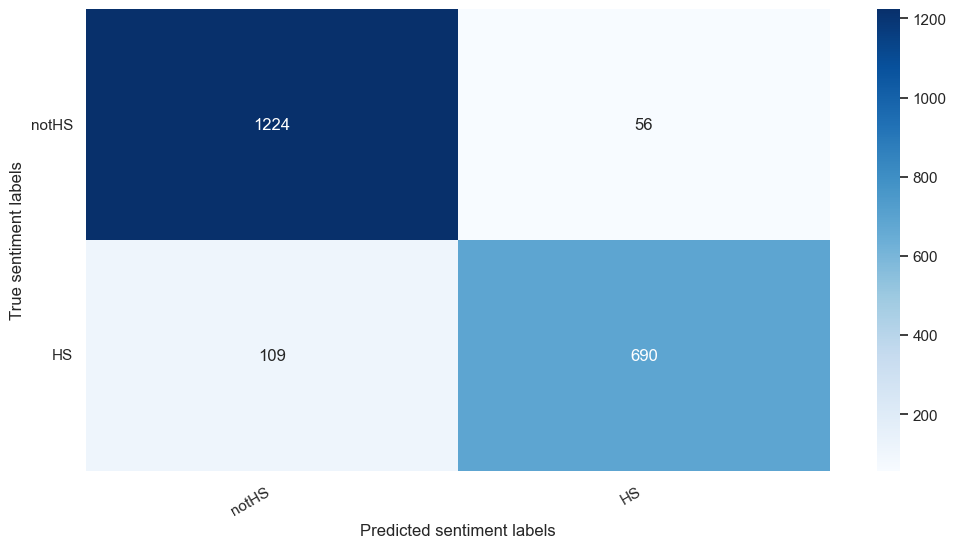

In [55]:
# https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment labels')
    plt.xlabel('Predicted sentiment labels');

cm = confusion_matrix(true_values, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [56]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=true_values, predict_vector=predictions)
cm.print_matrix()

Predict    0          1          
Actual
0          1224       56         

1          109        690        




In [57]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.92063
F1 Macro                                                          0.91503
FPR Macro                                                         0.09009
Kappa                                                             0.83018
NPV Macro                                                         0.92158
Overall ACC                                                       0.92063
PPV Macro                                                         0.92158
SOA1(Landis & Koch)                                               Almost Perfect
TPR Macro                                                         0.90991
Zero-one Loss                                                     165

Class Statistics :

Classes                                                           0             1             
ACC(Accuracy)                                                     0.92063       0.92063       
AUC(Area under the ROC 

# Create result table for test data

In [58]:
# get test data predictions
test_predictions, test_true_values = testing(model, test_dataloader, criterion)

#print(predictions, true_values)
#print(test_predictions)
#print(test_true_values)
print(len(test_predictions), len(test_true_values))

Evaluation of trained model on test data ... 
2079 2079


In [59]:
#print(test_data['text'])
#print(test_data['HSbinary'])

In [60]:
# create panda dataframe for test set
test_set_results = pd.DataFrame({'Sample':test_data['text'],'Actual Tags':test_data['HSbinary'],'Predicted Tags':test_predictions})
test_set_results.head(40)

,Sample,Actual Tags,Predicted Tags
4615,vittu joka,1,1
5503,murhe,0,0
5535,vittu näitä läskejä,1,1
3969,päästä,0,0
5662,mielikuvituksettomat,0,0
3355,Kuminaamakusettaja.,1,1
4295,pistää,0,0
7540,kaappi,0,0
3714,"Lisäksi, jos tätä tappaja syytä käytetään niin...",0,1
4991,onnettomuus,0,0


In [61]:
# The End # 